Mounted at /content/drive


Exp 3 : H(Z) vs E
No Optimiser

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 21.3 MB/s eta 0:00:00


Without Optimiser

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.5084 - loss: 90.7090 - val_accuracy: 0.6333 - val_loss: 4.7104
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5880 - loss: 12.1486 - val_accuracy: 0.5000 - val_loss: 12.0441
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5872 - loss: 8.2344 - val_accuracy: 0.6167 - val_loss: 7.1814
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7429 - loss: 2.4789 - val_accuracy: 0.7500 - val_loss: 2.5929
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8203 - loss: 1.3747 - val_accuracy: 0.7500 - val_loss: 2.0228
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9128 - loss: 0.3310 - val_accuracy: 0.7667 - val_loss: 1.5890
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8753 - loss: 0.6875 - val_accuracy: 0.7333 - val_loss: 1.3875
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9328 - loss: 0.1850 - val_accuracy: 0.7000 - val_loss: 2.0434
Epoch 

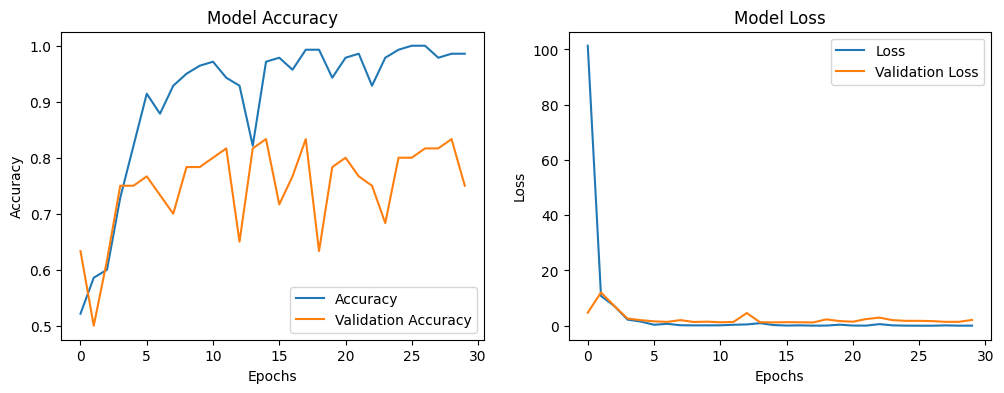

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN/Exp3/No_Options.keras ✅


In [ ]:
import os
import numpy as np
import pywt  # For wavelet decomposition
import time  # To calculate training time
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

# Function to load data from a directory and apply wavelet transform (db4, level 5)
def load_data_from_directory(directory_path, label, wavelet='db4', level=5):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file and apply wavelet transform
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            # Apply discrete wavelet transform (db4, level 5)
            coeffs = pywt.wavedec(file_data, wavelet, level=level)
            # Use only the approximation coefficients (first element of coeffs)
            wavelet_features = coeffs[0]
            data.append(wavelet_features)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Paths to your datasets
path_Z = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'  # Z (Healthy)
path_N = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'  # N (Epileptic)

# Load data
data_Z, labels_Z = load_data_from_directory(path_Z, label=0)  # Z (label 0 - Healthy)
data_N, labels_N = load_data_from_directory(path_N, label=1)  # N (label 1 - Epileptic)

# Combine data and labels
if data_Z.size > 0 and data_N.size > 0:
    data_all = np.concatenate((data_Z, data_N), axis=0)
    labels_all = np.concatenate((labels_Z, labels_N), axis=0)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Define the CNN model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification (0 for Z, 1 for N)
    ])

    # Compile the model
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])

    # Start timer for training time
    start_time = time.time()

    # Train the model
    history = model.fit(X_train[..., np.newaxis], y_train, epochs=30, batch_size=32, validation_data=(X_test[..., np.newaxis], y_test), verbose=1)

    # Stop timer and calculate training time
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time: {training_time:.2f} seconds")

    # Evaluate the model
    y_pred = model.predict(X_test[..., np.newaxis])
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)  # Sensitivity
    precision = precision_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")


      # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN/Exp3/No_Options.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")


With Standerscaler

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4987 - loss: 8.6551 - val_accuracy: 0.4833 - val_loss: 0.8898
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6587 - loss: 0.7530 - val_accuracy: 0.9500 - val_loss: 0.3789
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8112 - loss: 0.4898 - val_accuracy: 0.9667 - val_loss: 0.2772
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9510 - loss: 0.2762 - val_accuracy: 0.9333 - val_loss: 0.3589
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 988ms/step - accuracy: 0.8731 - loss: 0.2821 - val_accuracy: 0.9500 - val_loss: 0.3193
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9380 - loss: 0.2031 - val_accuracy: 0.9667 - val_loss: 0.2193
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9777 - loss: 0.1167 - val_accuracy: 0.9667 - val_loss: 0.1787
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 707ms/step - accuracy: 1.0000 - loss: 0.0359 - val_accuracy: 0.9667 - val_loss: 0.1301
Epoch 9/

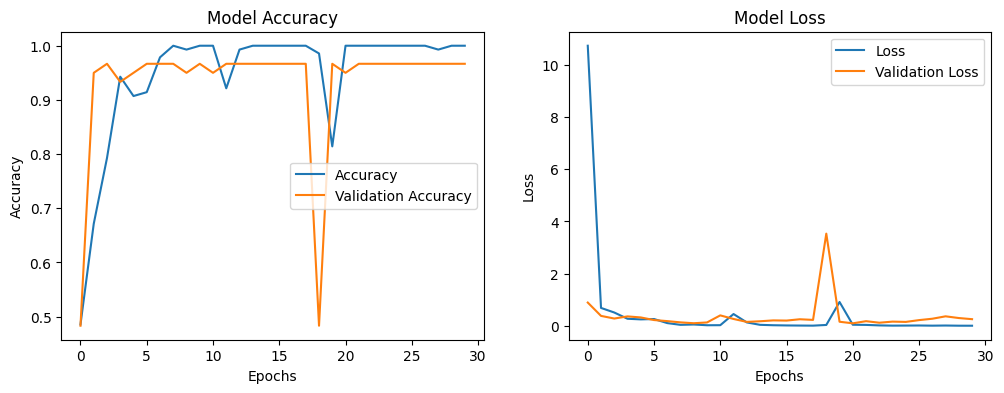

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN/Exp3/With_Stander.keras ✅


In [ ]:
import os
import numpy as np
import pywt  # Import PyWavelets for wavelet transform
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import time

# Function to load data from a directory
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Function to apply wavelet decomposition (db4) at level 5
def apply_wavelet_decomposition(data, wavelet='db4', level=5):
    decomposed_data = []
    for sample in data:
        coeffs = pywt.wavedec(sample, wavelet, level=level)
        # Flatten the coefficients and add to the list
        flattened_coeffs = np.concatenate(coeffs)
        decomposed_data.append(flattened_coeffs)
    return np.array(decomposed_data)

# Paths to your datasets
path_Z = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'  # Z (Healthy)
path_N = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'  # N (Epileptic)

# Load data
data_Z, labels_Z = load_data_from_directory(path_Z, label=0)  # Z (label 0 - Healthy)
data_N, labels_N = load_data_from_directory(path_N, label=1)  # N (label 1 - Epileptic)

# Combine data and labels
if data_Z.size > 0 and data_N.size > 0:
    data_all = np.concatenate((data_Z, data_N), axis=0)
    labels_all = np.concatenate((labels_Z, labels_N), axis=0)

    # Apply wavelet decomposition
    data_all = apply_wavelet_decomposition(data_all, wavelet='db4', level=5)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Reshape the data to be compatible with Conv1D
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Define the CNN model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification (0 for Z, 1 for N)
    ])

    # Compile the model
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])

    # Record the start time
    start_time = time.time()

    # Train the model
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Record the end time
    end_time = time.time()

    # Calculate the training time
    training_time = end_time - start_time
    print(f"Training time: {training_time:.2f} seconds")

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)  # Sensitivity
    precision = precision_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")


        # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN/Exp3/With_Stander.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")


With Optimiser

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5768 - loss: 103.6096 - val_accuracy: 0.5167 - val_loss: 38.3752
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 723ms/step - accuracy: 0.7266 - loss: 21.6906 - val_accuracy: 0.4833 - val_loss: 13.8211
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 977ms/step - accuracy: 0.6140 - loss: 10.6560 - val_accuracy: 0.9667 - val_loss: 0.2404
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 716ms/step - accuracy: 0.8988 - loss: 0.6689 - val_accuracy: 0.8833 - val_loss: 0.4214
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 723ms/step - accuracy: 0.9263 - loss: 0.2749 - val_accuracy: 0.9667 - val_loss: 0.1981
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9378 - loss: 0.2798 - val_accuracy: 0.9000 - val_loss: 0.2792
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9631 - loss: 0.1541 - val_accuracy: 0.9167 - val_loss: 0.2146
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9868 - loss: 0.1045 - val_accuracy: 0.9333 - val_loss: 0.2

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step

Final Evaluation Metrics:
Test Accuracy:  0.9666666666666667
Test Recall (Sensitivity):  0.9655172413793104
Test Precision:  0.9655172413793104
Test Specificity:  0.967741935483871
Confusion Matrix: 
 [[30  1]
 [ 1 28]]


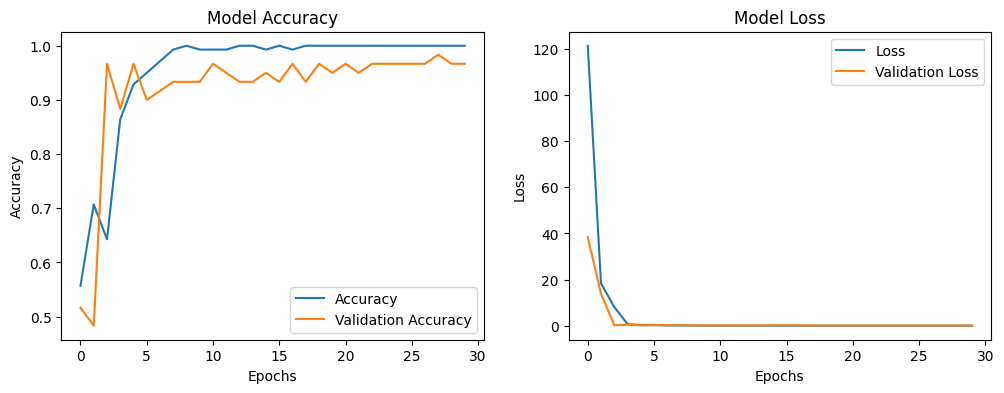

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN/Exp3/With_Optimiser.keras ✅


In [ ]:
import os
import numpy as np
import pywt  # Import PyWavelets for wavelet transform
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import time

# Function to load data from a directory
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Function to apply wavelet decomposition (db4) at level 5
def apply_wavelet_decomposition(data, wavelet='db4', level=5):
    decomposed_data = []
    for sample in data:
        coeffs = pywt.wavedec(sample, wavelet, level=level)
        # Flatten the coefficients and add to the list
        flattened_coeffs = np.concatenate(coeffs)
        decomposed_data.append(flattened_coeffs)
    return np.array(decomposed_data)

# Paths to your datasets
path_Z = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'  # Z (Healthy)
path_N = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'  # N (Epileptic)

# Load data
data_Z, labels_Z = load_data_from_directory(path_Z, label=0)  # Z (label 0 - Healthy)
data_N, labels_N = load_data_from_directory(path_N, label=1)  # N (label 1 - Epileptic)

# Combine data and labels
if data_Z.size > 0 and data_N.size > 0:
    data_all = np.concatenate((data_Z, data_N), axis=0)
    labels_all = np.concatenate((labels_Z, labels_N), axis=0)

    # Apply wavelet decomposition
    data_all = apply_wavelet_decomposition(data_all, wavelet='db4', level=5)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Reshape the data to be compatible with Conv1D
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Define the CNN model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification (0 for Z, 1 for N)
    ])

    # Compile the model with Adam optimizer
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Record the start time
    start_time = time.time()

    # Train the model
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Record the end time
    end_time = time.time()

    # Calculate the training time
    training_time = end_time - start_time
    print(f"Training time: {training_time:.2f} seconds")

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)  # Sensitivity
    precision = precision_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")




     # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN/Exp3/With_Optimiser.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")



with both op and standarisation

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 882ms/step - accuracy: 0.4764 - loss: 5.8548 - val_accuracy: 0.5167 - val_loss: 1.8937
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5481 - loss: 2.4062 - val_accuracy: 0.9667 - val_loss: 0.3530
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 758ms/step - accuracy: 0.7385 - loss: 0.5460 - val_accuracy: 0.5167 - val_loss: 0.6217
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6686 - loss: 0.6929 - val_accuracy: 1.0000 - val_loss: 0.5441
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 809ms/step - accuracy: 0.9538 - loss: 0.4861 - val_accuracy: 0.9500 - val_loss: 0.5056
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 743ms/step - accuracy: 0.9671 - loss: 0.4053 - val_accuracy: 0.9833 - val_loss: 0.3879
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9634 - loss: 0.2597 - val_accuracy: 0.9667 - val_loss: 0.2836
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 821ms/step - accuracy: 0.9696 - loss: 0.1576 - val_accuracy: 0.9667 - val_loss: 0.1571


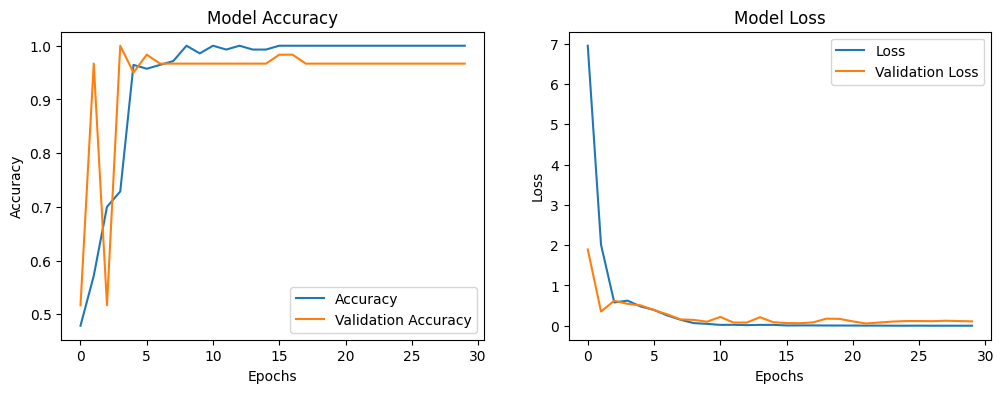

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN/Exp3/With_Options.keras ✅


In [ ]:
import os
import numpy as np
import pywt  # Import PyWavelets for wavelet transform
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler  # Import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import time

# Function to load data from a directory
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Function to apply wavelet decomposition (db4) at level 5
def apply_wavelet_decomposition(data, wavelet='db4', level=5):
    decomposed_data = []
    for sample in data:
        coeffs = pywt.wavedec(sample, wavelet, level=level)
        # Flatten the coefficients and add to the list
        flattened_coeffs = np.concatenate(coeffs)
        decomposed_data.append(flattened_coeffs)
    return np.array(decomposed_data)

# Paths to your datasets
path_Z = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'  # Z (Healthy)
path_N = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'  # N (Epileptic)

# Load data
data_Z, labels_Z = load_data_from_directory(path_Z, label=0)  # Z (label 0 - Healthy)
data_N, labels_N = load_data_from_directory(path_N, label=1)  # N (label 1 - Epileptic)

# Combine data and labels
if data_Z.size > 0 and data_N.size > 0:
    data_all = np.concatenate((data_Z, data_N), axis=0)
    labels_all = np.concatenate((labels_Z, labels_N), axis=0)

    # Apply wavelet decomposition
    data_all = apply_wavelet_decomposition(data_all, wavelet='db4', level=5)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Reshape the data to be compatible with Conv1D
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Define the CNN model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification (0 for Z, 1 for N)
    ])

    # Compile the model with Adam optimizer
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Record the start time
    start_time = time.time()

    # Train the model
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Record the end time
    end_time = time.time()

    # Calculate the training time
    training_time = end_time - start_time
    print(f"Training time: {training_time:.2f} seconds")

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)  # Sensitivity
    precision = precision_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")




     # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN/Exp3/With_Options.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")

